In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

# read dataset

def read_data(path, limiter):
    """
    Args:
        path: path to dataset in jsonl file format
        limiter: number of rows

    Returns:
        data: json dict, where every line is one sample as json
    """
    with open(path) as file:
        data = [json.loads(next(file)) for x in range(limiter)]
    return data


def transform_dict(json_dict):
    """
    Args:
        json_dict: json dict with nested key-value, where value is list

    Returns:
        functions_dict: dict with value as a key and default value True
    """
    result_dict = {}
    for key in json_dict.keys():
        keys = json_dict[key]
        values_with_default = {key.lower() + "-" + f_name: True for f_name in keys}
        result_dict.update(values_with_default)
    return result_dict


def transform_list(json_list):
    """
    Args:
        json_list: json list of values

    Returns:
        functions_dict: dict with all dll functions name with value True
    """
    result_dict = {}
    result_dict.update({i: True for i in json_list})
    return result_dict

# 1. read datas
data_path = 'C:/Users/zyche/Downloads/sample_data_6k.jsonl'
data = read_data(data_path, limiter=2000)

df = pd.DataFrame(data)
flatten_imports = []
flatten_exports = []
flatten_dataset = []
for sample in data:
    transformed = {}
    transformed_imports = {}
    transformed_exports = {}
    transformed.update({"label" : sample['label']})
    transformed.update(transform_dict(sample['imports']))
    transformed.update(transform_list(sample['exports']))
    
    transformed_imports.update({"label" : sample['label']})
    transformed_imports.update(transform_dict(sample['imports']))
    
    transformed_exports.update({"label" : sample['label']})
    transformed_exports.update(transform_list(sample['exports']))

    # here we fill with transform data
    flatten_imports.append(transformed_imports)
    flatten_exports.append(transformed_exports)
    flatten_dataset.append(transformed)

# change all transformed dataset to dataframe object
flatten_df = pd.DataFrame(flatten_dataset)

In [2]:
# how many empty exports in all set

empty_exports = df[~df.exports.astype(bool)].exports.count()

empty_exports_count = df[df['exports'].map(lambda d: len(d)) == 0].exports.count()

empty_count_percent = (empty_exports_count / df.exports.size) * 100

print("There is %2f %% of empty exports" % empty_count_percent)



There is 80.800000 % of empty exports


In [3]:
# how many empty imports in all set

empty_imports = df[~df.imports.astype(bool)].imports.count()

empty_imports_count = df[df['imports'].map(lambda d: len(d)) == 0].imports.count()

empty_imports_count_percent = (empty_imports_count / df.imports.size) * 100

print("There is %2f %% of empty imports" % empty_imports_count_percent)


There is 10.000000 % of empty imports


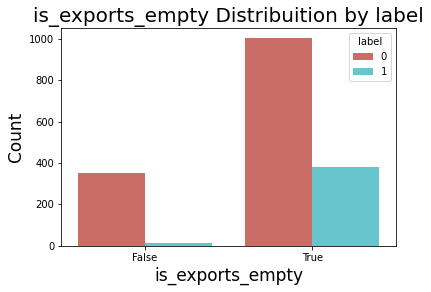

In [4]:
# not empty exports by label

label_exports_df = df[['label', 'exports']]
label_exports_df = label_exports_df[label_exports_df.label != -1]
label_exports_df['exports'] = label_exports_df['exports'].map(lambda a: len(a) == 0)

sns.countplot(x="exports", data=label_exports_df, hue="label",palette="hls")
plt.title('is_exports_empty Distribuition by label', fontsize=20)
plt.xlabel('is_exports_empty',fontsize=17)
plt.ylabel('Count', fontsize=17)

plt.show()



In [5]:
# check wich export function are unique for label
label_exports_df = df[['label', 'exports']]
label_exports_malware = label_exports_df[label_exports_df.label == 1]
label_exports_bening = label_exports_df[label_exports_df.label == 0]

#all_export_function_malware = label_exports_malware.exports.sum()
#all_export_function_bening = label_exports_bening.exports.sum()
#print(label_exports_malware.exports.sum())
#unique_functions_for_malware = [i for i in all_export_function_malware if i not in set(all_export_function_bening)]
#unique_functions_for_bening = [i for i in all_export_function_bening if i not in set(all_export_function_malware)]


#print("There is %d malware function and %d malware function which also are in bening functions" % (len(all_export_function_malware), len(unique_functions_for_malware)))
#print("There is %d bening function and %d bening function which also are in malware functions" % (len(all_export_function_bening), len(unique_functions_for_bening)))

In [6]:
# frequncy functions for beningwares
bening_ware = flatten_df[flatten_df['label']==0]
bening_ware_function_df = bening_ware.loc[ : , bening_ware.columns != 'label'] 
bening_ware_function_df.count().reset_index().rename(
           columns={'index': 'function', 0: 'count'})

df_counts_bening_fun = bening_ware_function_df.count().reset_index().rename(
           columns={'index': 'function', 0: 'count'}).sort_values(by=['count'], ascending=False).head(50)


df_counts_bening_fun


,function,count
53,kernel32.dll-GetProcAddress,667
9,kernel32.dll-GetLastError,653
51,kernel32.dll-GetModuleHandleA,618
17,kernel32.dll-GetCurrentProcess,611
22,kernel32.dll-CloseHandle,608
52,kernel32.dll-LoadLibraryA,604
55,kernel32.dll-MultiByteToWideChar,553
15,kernel32.dll-GetModuleFileNameA,547
59,kernel32.dll-WriteFile,543
389,kernel32.dll-GetCurrentThreadId,541


In [7]:

# frequncy functions for beningwares
malwares = flatten_df[flatten_df['label']==0]
malware_function_df = malwares.loc[ : , bening_ware.columns != 'label'] 
malware_function_df.count().reset_index().rename(
           columns={'index': 'function', 0: 'count'})

malware_count_function_df = malware_function_df.count().reset_index().rename(
           columns={'index': 'function', 0: 'count'}).sort_values(by=['count'], ascending=False).head(50)


malware_count_function_df



,function,count
53,kernel32.dll-GetProcAddress,667
9,kernel32.dll-GetLastError,653
51,kernel32.dll-GetModuleHandleA,618
17,kernel32.dll-GetCurrentProcess,611
22,kernel32.dll-CloseHandle,608
52,kernel32.dll-LoadLibraryA,604
55,kernel32.dll-MultiByteToWideChar,553
15,kernel32.dll-GetModuleFileNameA,547
59,kernel32.dll-WriteFile,543
389,kernel32.dll-GetCurrentThreadId,541


In [8]:
# chi2 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
# no of maximum features we need to select

flatten_all_df = flatten_df.fillna(False)
num_feats=30
y = flatten_all_df['label'] == 1
X = flatten_all_df.copy()
del X['label']


X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print(chi_feature)

# https://medium.com/mrx-007/basic-static-analysis-of-malware-and-common-dll-ef9455d49968

30 selected features
['advapi32.dll-ConvertStringSecurityDescriptorToSecurityDescriptorA', 'advapi32.dll-CryptAcquireContextW', 'kernel32.dll-GetEnvironmentVariableW', 'kernel32.dll-WaitForSingleObjectEx', 'kernel32.dll-LoadLibraryExW', 'version.dll-VerQueryValueW', 'kernel32.dll-OutputDebugStringW', 'kernel32.dll-GetStartupInfoW', 'shlwapi.dll-UrlEscapeW', 'shlwapi.dll-UrlUnescapeW', 'shell32.dll-SHGetFolderPathW', 'kernel32.dll-IsValidLocale', 'kernel32.dll-IsProcessorFeaturePresent', 'user32.dll-CreateAcceleratorTableW', 'kernel32.dll-ReadConsoleW', 'kernel32.dll-SetFilePointerEx', 'advapi32.dll-GetSecurityDescriptorSacl', 'advapi32.dll-SetSecurityDescriptorSacl', 'kernel32.dll-GetModuleHandleExW', 'user32.dll-InternalGetWindowText', 'kernel32.dll-Module32FirstW', 'user32.dll-DestroyAcceleratorTable', 'kernel32.dll-EnumSystemLocalesW', 'netapi32.dll-NetWkstaGetInfo', 'kernel32.dll-GetSystemWow64DirectoryW', 'kernel32.dll-InitializeSListHead', 'oleacc.dll-AccessibleObjectFromWindow',

In [ ]:
#chi2 for imports
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
# no of maximum features we need to select

flatten_imports_df = pd.DataFrame(flatten_imports)
flatten_imports_df = flatten_imports_df.fillna(False)

num_feats=30
y = flatten_imports_df['label'] == 1
X = flatten_imports_df.copy()
del X['label']


X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print(chi_feature)

In [ ]:
#chi2 for exports
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
# no of maximum features we need to select

flatten_exports_df = pd.DataFrame(flatten_exports)
flatten_exports_df = flatten_exports_df.fillna(False)

num_feats=30
y = flatten_exports_df['label'] == 1
X = flatten_exports_df.copy()
del X['label']


X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')
print(chi_feature)